In [14]:
from catboost import CatBoostRegressor
from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize
)
from utils.model import ModelEvalWrapper

In [15]:
train_df, predict_df = load_data('../data')

In [16]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        standardize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                "frequency_cell0",
                "frequency_cell1",
                "frequency_cell2",
                "frequency_cell3",
            ]
        ),
        drop_non_input_cols,
    ],
)

In [17]:
kf = model_selection.KFold(n_splits=10)
kf = kf.split(X=train_1)
oof_valid_preds_cat = np.zeros(train_1.shape[0])
oof_valid_preds_lgbm = np.zeros(train_1.shape[0], )
test_preds_list_cat= []
test_preds_list_lgbm = []


In [5]:
for i, (train_idx, valid_idx) in enumerate(kf):

model_getter = lambda: CatBoostRegressor(**params)
model_trainer = lambda model, X, y, *args, **kwargs: model.fit(X, y, verbose=False)
model_predictor = lambda model, X: model.predict(X)
model_eval = ModelEvalWrapper(
    model_getter,
    name="Basic Linear Regression",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

    train1, valid_df, test_df = feature_enginning(train1=train1, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train1.columns if col not in drop_cols]

    X_train, y_train = train1[train_cols], train1[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'iterations': 10000,
        'learning_rate': 0.01,
        'depth': 6,
        'loss_function': 'MAE',
        'verbose': 100,
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=100,
        verbose=100,
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds_cat[valid_idx] = valid_preds
    test_preds_list_cat.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score_cat = metrics.mean_absolute_error(train_1[target_col], oof_valid_preds_cat)
print("_-*"*50)
print(f"OOF score : ", oof_score_cat)


0:	learn: 10.5779008	test: 10.1482334	best: 10.1482334 (0)	total: 235ms	remaining: 39m 5s
100:	learn: 5.4032953	test: 5.3062625	best: 5.3062625 (100)	total: 2.09s	remaining: 3m 24s
200:	learn: 3.7792921	test: 3.8710113	best: 3.8710113 (200)	total: 3.35s	remaining: 2m 43s
300:	learn: 3.2278073	test: 3.3395058	best: 3.3395058 (300)	total: 4.8s	remaining: 2m 34s
400:	learn: 2.9778776	test: 3.0452250	best: 3.0452250 (400)	total: 5.98s	remaining: 2m 23s
500:	learn: 2.8474375	test: 2.9025963	best: 2.9025963 (500)	total: 7.39s	remaining: 2m 20s
600:	learn: 2.7712620	test: 2.8299895	best: 2.8299895 (600)	total: 10.6s	remaining: 2m 46s
700:	learn: 2.7135929	test: 2.7787008	best: 2.7787008 (700)	total: 12.7s	remaining: 2m 48s
800:	learn: 2.6607924	test: 2.7312100	best: 2.7312100 (800)	total: 13.9s	remaining: 2m 39s
900:	learn: 2.6147910	test: 2.6949230	best: 2.6949230 (900)	total: 15s	remaining: 2m 31s
1000:	learn: 2.5769128	test: 2.6623620	best: 2.6623620 (1000)	total: 16.2s	remaining: 2m 26s
1

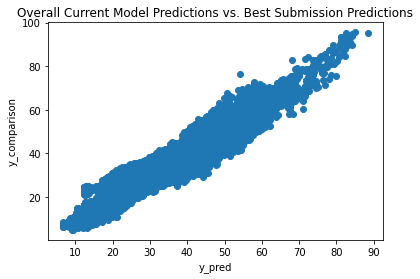

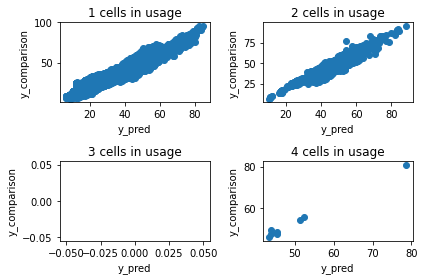

In [6]:
test_preds_mean_cat = np.mean(test_preds_list_cat, axis=0)
test_data['Energy'] = test_preds_mean_cat
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']
ss_df = pd.read_csv('../data/SampleSubmission.csv')
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [7]:

ss_df.to_csv("catboost.csv", index=False)

In [18]:
for i, (train_idx, valid_idx) in enumerate(kf):

    train1 = train_1.iloc[train_idx]
    valid_df = train_1.iloc[valid_idx]
    test_df = test_data.copy()

    train1, valid_df, test_df = feature_enginning(train1=train1, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train1.columns if col not in drop_cols]

    X_train, y_train = train1[train_cols], train1[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        # 'learning_rate': 0.01,
        'n_jobs': -1,
        'max_depth' : -1,
        'metric': 'mae',
        'num_boost_round': 10000,
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping_callback, verbose_callback],
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds_lgbm[valid_idx] = valid_preds
    test_preds_list_lgbm.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score_lgbm = metrics.mean_absolute_error(train_1[target_col], oof_valid_preds_lgbm)
print("_-*"*50)
print(f"OOF score : ", oof_score_lgbm)

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 83366, number of used features: 79
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.290304
[100]	valid_0's l1: 2.07686
[200]	valid_0's l1: 1.85079
[300]	valid_0's l1: 1.75836
[400]	valid_0's l1: 1.68728
[500]	valid_0's l1: 1.6249
[600]	valid_0's l1: 1.58745
[700]	valid_0's l1: 1.56356
[800]	valid_0's l1: 1.53519
[900]	valid_0's l1: 1.51997
[1000]	valid_0's l1: 1.50509
[1100]	valid_0's l1: 1.49341
[1200]	valid_0's l1: 1.48704
[1300

In [19]:
test_preds_mean_lgbm = np.mean(test_preds_list_lgbm, axis=0)
test_data['Energy'] = test_preds_mean_lgbm
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']
ss_df = pd.read_csv('../data/SampleSubmission.csv')
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [20]:

ss_df.to_csv("lightgbm.csv", index=False)
